In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt


In [2]:
def R(x: np.ndarray) -> np.ndarray:
    """
    Rectified Linear Unit (ReLU) activation function.
    """
    return np.maximum(0, x)


def R_prime(x: np.ndarray) -> np.ndarray:
    """
    Derivative of the Rectified Linear Unit (ReLU) activation function.
    """
    return (x > 0).astype(float)


def sigmoid(z: np.ndarray) -> np.ndarray:
    #
    # $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
    #
    # return 1.0 / (1.0 + np.exp(-z))  # can overflow for large z
    computed = np.piecewise(  # https://stackoverflow.com/a/64717799
        z,
        [z > 0],
        [lambda i: 1 / (1 + np.exp(-i)), lambda i: np.exp(i) / (1 + np.exp(i))],
    )
    return np.clip(computed, 1e-15, 1 - 1e-15)


def predict(x: np.ndarray, params: np.ndarray) -> float:
    a, b, c, d, e, f, g, h, i, j, k, l, m = params  # noqa: E741

    # $$ \hat{y} = U^2 = j\cdot R(ax_1^0+bx_2^0+g) + k\cdot R(cx_1^0+dx_2^0+h) + l\cdot R(ex_1^0+fx_2^0+i) + m $$
    return (
        j * R(a * x[0] + b * x[1] + g)
        + k * R(c * x[0] + d * x[1] + h)
        + l * R(e * x[0] + f * x[1] + i)
        + m
    )


def loss(x: np.ndarray, y: float, params: np.ndarray) -> float:
    y_hat = predict(x, params)

    # $$ E(y, \hat{y}) = (y - \hat{y})^2 $$
    return (y - y_hat) ** 2


def grad(x: np.ndarray, y: float, params: np.ndarray) -> np.ndarray:
    """
    Compute the gradient of the loss with respect to the parameters.
    """
    a, b, c, d, e, f, g, h, i, j, k, l, m = params  # noqa: E741

    y_hat = predict(x, params)

    # $$ \frac{\partial E}{\partial j} = -2(y - \hat{y}) \cdot R(ax_1^0+bx_2^0+g) $$

    # $$ \frac{\partial E}{\partial a} = -2j(y - \hat{y}) \cdot R'(ax_1^0+bx_2^0+g) \cdot x_1^0 $$

    # $$ \frac{\partial E}{\partial g} = -2j(y - \hat{y}) \cdot R'(ax_1^0+bx_2^0+g) $$

    # $$ \frac{\partial E}{\partial m} = -2(y - \hat{y}) $$

    # likewise for (k, l); (b, c, d, e, f); (h, i); () respectively

    return np.array(
        [
            -2 * j * (y - y_hat) * R_prime(a * x[0] + b * x[1] + g) * x[0],  # ∂E/∂a
            -2 * j * (y - y_hat) * R_prime(a * x[0] + b * x[1] + g) * x[1],  # ∂E/∂b
            -2 * k * (y - y_hat) * R_prime(c * x[0] + d * x[1] + h) * x[0],  # ∂E/∂c
            -2 * k * (y - y_hat) * R_prime(c * x[0] + d * x[1] + h) * x[1],  # ∂E/∂d
            -2 * l * (y - y_hat) * R_prime(e * x[0] + f * x[1] + i) * x[0],  # ∂E/∂e
            -2 * l * (y - y_hat) * R_prime(e * x[0] + f * x[1] + i) * x[1],  # ∂E/∂f
            -2 * j * (y - y_hat) * R_prime(a * x[0] + b * x[1] + g),  # ∂E/∂g
            -2 * k * (y - y_hat) * R_prime(c * x[0] + d * x[1] + h),  # ∂E/∂h
            -2 * l * (y - y_hat) * R_prime(e * x[0] + f * x[1] + i),  # ∂E/∂i
            -2 * (y - y_hat) * R(a * x[0] + b * x[1] + g),  # ∂E/∂j
            -2 * (y - y_hat) * R(c * x[0] + d * x[1] + h),  # ∂E/∂k
            -2 * (y - y_hat) * R(e * x[0] + f * x[1] + i),  # ∂E/∂l
            -2 * (y - y_hat),  # ∂E/∂m
        ]
    )

1506 y=0; 1494 y=1


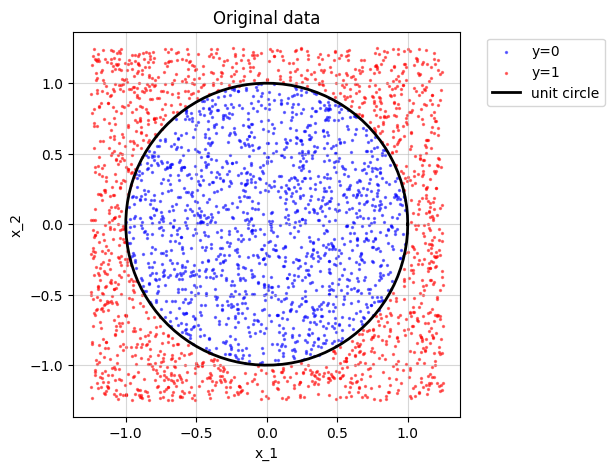

In [3]:
np.random.seed(42)
n_points = 3000

# x_1 and x_2 range: [-1.25, 1.25]
X = np.random.uniform(-1.25, 1.25, (n_points, 2))

# y = {0: inside unit circle, 1: outside unit circle}
y = (X[:, 0] ** 2 + X[:, 1] ** 2 > 1).astype(float)

print(f"{len(y[y == 0])} y=0; {len(y[y == 1])} y=1")

plt.figure(figsize=(5, 5))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="blue", alpha=0.5, label="y=0", s=2)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="red", alpha=0.5, label="y=1", s=2)

# draw unit circle parametrically
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = np.cos(theta)
circle_y = np.sin(theta)
plt.plot(circle_x, circle_y, "k-", linewidth=2, label="unit circle")

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.5)
plt.axis("equal")
plt.title("Original data")
plt.show()


In [4]:
params = np.random.normal(size=13, scale=0.1)  # gaussian distribution
lambda_ = 0.01

for _ in range(10):
    for x_i, y_i in zip(X, y):
        params -= lambda_ * grad(x_i, y_i, params)

y_pred = np.array(
    [predict(x_i, params) for x_i in X]
)  # FIXME: pred returns scalar, negligible for now

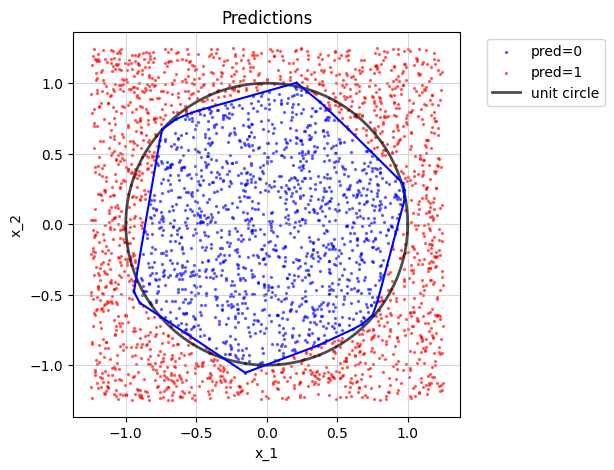

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(
    X[y_pred < 0.5, 0], X[y_pred < 0.5, 1], c="blue", alpha=0.5, label="pred=0", s=2
)
plt.scatter(
    X[y_pred >= 0.5, 0], X[y_pred >= 0.5, 1], c="red", alpha=0.5, label="pred=1", s=2
)

# draw unit circle parametrically
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = np.cos(theta)
circle_y = np.sin(theta)
plt.plot(circle_x, circle_y, "k-", linewidth=2, label="unit circle", alpha=0.7)

# see how well the blue matches the unit circle (ideal separation)
blue_points = X[y_pred < 0.5]
hull = ConvexHull(blue_points)

for simplex in hull.simplices:
    plt.plot(blue_points[simplex, 0], blue_points[simplex, 1], "b-")

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.5)
plt.axis("equal")
plt.title("Predictions")
plt.show()
